# Imports

In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Grabbing Data

In [32]:
df_all = pd.read_pickle("../../FantasyData/data-frames/df_all_2005_2023.pkl")

In [33]:
season = 2023
position = 'QB'

In [34]:
df_review = df_all.query(f"season == {season} and position == '{position}' and games >= 5").copy()

### Verifying Data

In [35]:
assert(df_review["position"].unique()[0] == position)
assert(df_review["season"].unique()[0] == season)
assert(df_review["games"].max() == 17)

# Clustering

## Selecting Stats for Clusters

In [36]:
qb_cols = ['completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',
       'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota']

In [37]:
df_review["completion_percentage"] = df_review["completions"] / df_review["attempts"]

In [38]:
# subset_cols = ['completions', 'attempts',
#        'passing_yards', 'passing_tds', 'interceptions']

In [61]:
# subset_cols = ['passing_yards', 'passing_tds', 'rushing_tds', 'rushing_yards', 'fantasy_points']
# subset_cols = ['fantasy_points', 'passing_yards', 'passing_tds', 'interceptions', 'completion_percentage', 'sacks']
# subset_cols = ['fantasy_points', 'pacr', 'dakota', 'passing_epa', 'passing_air_yards']
# subset_cols = ['fantasy_points', 'carries', 'rushing_yards', 'rushing_tds',]
subset_cols = ['fantasy_points', 'rushing_epa', 'rushing_first_downs']

### Per Game Option

In [62]:
per_game = True

In [63]:
if per_game:
    for col in subset_cols:
        if col != "completion_percentage":
            df_review[f"{col}_per_game"] = df_review[col]/ df_review["games"]
    
    for i, col in enumerate(subset_cols):
        if col != "completion_percentage":
            subset_cols[i] = f"{col}_per_game"

In [64]:
subset_df = df_review[subset_cols].copy().dropna()

In [65]:
subset_df = subset_df.sort_values(by="fantasy_points_per_game")[-30:]

In [66]:
subset_df.drop(columns="fantasy_points_per_game", inplace=True)

In [67]:
subset_cols = subset_cols[1:]

In [68]:
subset_df.head()

,rushing_epa_per_game,rushing_first_downs_per_game
11199,-0.173479,0.437500
8867,2.015010,1.000000
9901,-0.004659,0.800000
11192,1.607513,2.200000
8403,-1.192698,0.235294


## Creating Vectors for Clustering

In [69]:
X = subset_df.to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Get Candidate Cluster Size

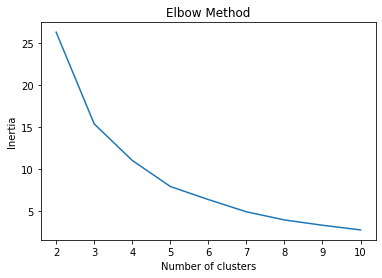

In [70]:
inertia = []
for i in range(2, 11):  # consider clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, algorithm='elkan', n_init=10).fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Create Clusters

In [71]:
n = 5

In [72]:
kmeans = KMeans(n_clusters=n, random_state=0, n_init=10).fit(X_scaled)

cluster_ranking = dict()
for i, cluster_num in enumerate(kmeans.labels_):
    cluster_ranking[df_review.loc[subset_df.index[i], 'player_name']] = cluster_num

labels = [str(label) for label in kmeans.labels_]

In [73]:
df_cluster = pd.DataFrame(X, columns=subset_cols)
df_cluster["Cluster"] = labels

# Graph Clusters

## Parameters for Graph

In [74]:
save_fig = True
save_suffix = ""

In [84]:
font_size = 12
marker_size = 4
diagonal_is_visible = False
width = 1000
height = 1000
showupperhalf = True
legend_size = 14

## Plot Generation

In [85]:
# Convert dictionary keys to a list
name_list = list(cluster_ranking.keys())

# Add the list as a new column to the dataframe
df_cluster['Names'] = name_list

df_cluster.set_index('Names', inplace=True)

fig = px.scatter_matrix(
    data_frame=df_cluster,
    dimensions=subset_cols,
    color="Cluster",
    hover_name=df_cluster.index,  # Assuming the player's name is the index
    labels={col: col for col in subset_cols}  # Optional if you want to customize axis labels
)

# Customize the appearance (optional)
fig.update_traces(diagonal_visible=diagonal_is_visible, showupperhalf=showupperhalf)

# improving UI
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',   # Transparent background outside the plot
    plot_bgcolor='rgba(245, 245, 245, 1)',  # Light gray plot background
    showlegend=True,
    font=dict(
        family="Courier New, monospace",  # Choose a font family
        size=font_size,  # Adjust the font size
        color="black"  # Font color
    )
)
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='rgba(200, 200, 200, 0.5)')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='rgba(200, 200, 200, 0.5)')

fig.update_layout(width=width, height=height)  # Adjust as necessary
fig.update_traces(marker=dict(size=marker_size))  # Adjust marker size as needed

fig.update_layout(legend=dict(font=dict(size=legend_size)))

# Save the plot as HTML
if save_fig:
    fig.write_html("../../interactive-2.0/QB/2023-review-pt3/cluster_advanced_per_game.html")

fig.show()

In [86]:
import pandas as pd

# <h3 class="h3-blog">WRs as Three Tiers</h3>
#             <p class="blog-p-tag">
#                 Starting off with three tiers:
#             </p>
#             <div class="iframe-container">
#                 <iframe class="large-iframe" data-src="/Fantasy/Analysis/interactive/QB/clustering-3.html"></iframe>
#             </div>

num_2_word = {
    3: "Three",
    4: "Four",
    5: "Five",
    6: "Six",
    7: "Seven"
}
STARTING_INDENT = 3

def indent(num_indents):
    return "\t" * num_indents

def html_breaking_down_clusters(keys, suffix):
    """"""
    print(f"{indent(STARTING_INDENT)}<div>")
    
    print(f"{indent(STARTING_INDENT + 1)}<h3 class='h3-blog'>{position}s as {num_2_word[len(keys)]} Tiers</h3>")
    print(f"{indent(STARTING_INDENT + 1)}<p class='blog-p-tag'>")
    print(f"{indent(STARTING_INDENT + 2)}TODO")
    print(f"{indent(STARTING_INDENT + 1)}</p>")
    print(f"{indent(STARTING_INDENT + 1)}<div class='iframe-container'>")
    if suffix:
        append = f"-{suffix}"
    else:
        append = ""
    print(f"{indent(STARTING_INDENT + 2)}<iframe class='large-iframe' data-src='/Fantasy/Analysis/interactive/{position}/clustering-{len(keys)}{append}.html'></iframe>")
    print(f"{indent(STARTING_INDENT + 1)}</div>")
    
    print(f"{indent(STARTING_INDENT + 1)}<p class='blog-p-tag'>")
    print(f"{indent(STARTING_INDENT + 2)}TODO:")
    print(f"{indent(STARTING_INDENT + 2)}<ul class='bullet-list'>")
    for key in keys:
        print(f"{indent(STARTING_INDENT + 3)}<li><b>Cluster {key}:</b> TODO</li>")
        
    print(f"{indent(STARTING_INDENT + 2)}</ul>")

def create_cluster_html_tiers(df: pd.DataFrame, suffix: str) -> None:
    cluster_dict = dict()
    for index, row in df.iterrows():
        if row.Cluster not in cluster_dict:
            cluster_dict[row.Cluster] = [index]
        else:
            cluster_dict[row.Cluster].append(index)
            
    sorted_cluster_dict = dict(sorted(cluster_dict.items()))
    keys = list(sorted_cluster_dict.keys())
    
    
    html_breaking_down_clusters(keys, suffix)
    print(f"{indent(STARTING_INDENT + 1)}<div style='display: flex; justify-content: space-evenly;''>")
    for key in keys:
        names = cluster_dict[key]
        
        print(f"{indent(STARTING_INDENT + 2)}<div>")
        print(f"{indent(STARTING_INDENT + 3)}<b>Cluster {key} ()</b>")
        print(f"{indent(STARTING_INDENT + 3)}<ul class='bullet-list'>")
        for name in names:
            print(f"{indent(STARTING_INDENT + 4)}<li>{name}</li>")
        print(f"{indent(STARTING_INDENT + 3)}</ul>")
        print(f"{indent(STARTING_INDENT + 2)}</div>")
        if key != keys[-1]:
            print()
    print(f"{indent(STARTING_INDENT + 1)}</div>")
    print(f"""{indent(STARTING_INDENT + 1)}</p>
{indent(STARTING_INDENT + 1)}<p class="blog-p-tag">
{indent(STARTING_INDENT + 2)}TODO
{indent(STARTING_INDENT + 1)}</p>""")
    print(f"{indent(STARTING_INDENT)}</div>")

In [87]:
print(f"{indent(STARTING_INDENT - 1)}<div>")
create_cluster_html_tiers(df_cluster, "")
print()
print(f"{indent(STARTING_INDENT - 1)}</div>")

		<div>
			<div>
				<h3 class='h3-blog'>QBs as Five Tiers</h3>
				<p class='blog-p-tag'>
					TODO
				</p>
				<div class='iframe-container'>
					<iframe class='large-iframe' data-src='/Fantasy/Analysis/interactive/QB/clustering-5.html'></iframe>
				</div>
				<p class='blog-p-tag'>
					TODO:
					<ul class='bullet-list'>
						<li><b>Cluster 0:</b> TODO</li>
						<li><b>Cluster 1:</b> TODO</li>
						<li><b>Cluster 2:</b> TODO</li>
						<li><b>Cluster 3:</b> TODO</li>
						<li><b>Cluster 4:</b> TODO</li>
					</ul>
				<div style='display: flex; justify-content: space-evenly;''>
					<div>
						<b>Cluster 0 ()</b>
						<ul class='bullet-list'>
							<li>Taylor Heinicke</li>
							<li>Deshaun Watson</li>
							<li>Sam Howell</li>
							<li>Jake Browning</li>
							<li>Patrick Mahomes</li>
							<li>Justin Herbert</li>
							<li>C.J. Stroud</li>
							<li>Kyler Murray</li>
							<li>Brock Purdy</li>
							<li>Dak Prescott</li>
						</ul>
					</div>

					<div>
			